In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib.ticker as ticker
import matplotlib.patches as patches

# plt.rc('text', usetex=True)
# plt.rc('text.latex', preamble=r'\usepackage{extarrows}')

plt.style.use('fivethirtyeight')
np.random.seed(0)

$$
\begin{align}
T(\mathbf{x}) = & \left[\begin{array}{c}
x\\
x^2
\end{array}\right] \\
\boldsymbol{\theta} = & \left[\begin{array}{c}
\frac{\mu}{\sigma^2}\\
-\frac{1}{2\sigma^2}
\end{array}\right] \\
h(\mathbf{x}) = & 1 \\
\log Z(\boldsymbol{\theta}) = & \frac{1}{2\sigma^2}\mu^2+\log\sigma + \frac{1}{2}\log (2\pi)
\end{align}
$$

### Generate some data

In [57]:
#normal
N_norm = 1000
loc = 3.5
scale = 2
data_normal = np.random.normal(loc=loc,scale=scale,size=N_norm)

#bernoulli
N_ber = 1000
prob_B = .35
data_ber = np.array(['A']*N_ber)
data_ber[np.random.uniform(size=N_ber)>prob_B] = 'A'

#multinomial
N_mult = 1000
probs = [.2,.35,.45]
sum_mult = 10
data_mult = np.random.multinomial(sum_mult,probs,N_mult)

data_mult_df = pd.DataFrame(data_mult,columns = ['A','B','C'])

def mult_combinations(sum_mult):
    
    out = []
    
    for x1 in range(sum_mult+1):
        for x2 in range(sum_mult-x1+1):
            x3 = sum_mult-(x1+x2)
            out.append([x1,x2,x3])
            
    return np.array(out)
    
mult_combs = mult_combinations(sum_mult)

def size_of_X(sum_amount,n_cats):
    return np.math.factorial(sum_amount+n_cats-1)/(np.math.factorial(sum_amount)*np.math.factorial(n_cats-1))

assert len(mult_combs) == size_of_X(10,3)

# Final Answer

I'd like to give a different perspective on the exponential family. The general pattern of explanation for the exponential family is to give it's definition and then show how familiar distributions fit into that form. This has it's merits, but I'd like to reason from somewhere else: the observation of the data. From here, we say 'the data is like thisa, can we handle it with the exponential family?' As we discover we can handle a diversity of data, we'll see how flexible the exponentail family is.

I'll start with a real simple problem, how the exponential family helps in that familiar circumstance and how it can, in fact, help in much broader circumstances. 

Before dividing in, I'll tell you that this is quite a long answer, but for very good reason. If you can master the exponential family, you immediately understand a wide class of distributions. On a per minute-of-study basis, it's a worthwhile purchase.

Ok, let's get started. Let's say we've come across a list of continuous numbers that 'look' normally distributed. Our goal is to determine which distribution generated these numbers. That is, we speculate a distribution (normal in this case) and determine which parameters of that distribution make the most sense according to the data. 'Makes the most sense' translates to pick the maximum likelihood parameters.

Now, before you say, 'just use the empirical mean/variance', let's think about exactly what we are doing. We are concerned with finding the parameters $\mu$ and $\sigma^2$ that maximize the likelihood of our data. That is, find me $\mu^*$ and $\sigma^{2*}$:

$$
\mu^*,\sigma^{2*} = \textrm{argmax}_{\mu,\sigma^2} \prod_i^N \mathcal{N}(x_i | \mu,\sigma^2)
$$

The answer happens to be the empirical mean and variance, but that solution doesn't generalize, so forget it! Let's scan for values of $\mu$ and $\sigma^2$ until we find a combination that works. That process looks like this:

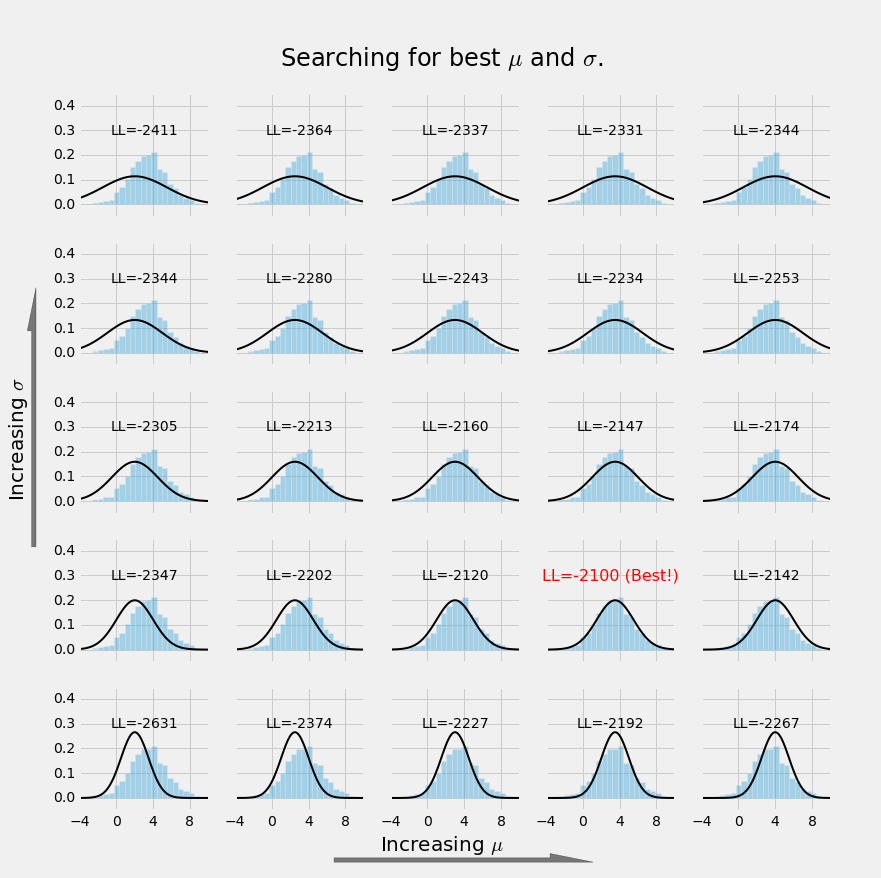

In [3]:
mus = [2,2.5,3,3.5,4]
stds = [3.5,3,2.5,2,1.5]

eps = 0.05
ylims = [0-eps,.4+eps]
xlims = [-4-eps,10+eps]

def setup_grid_fig(sym1,sym2):
    
    fig, axarr = plt.subplots(len(stds),len(mus),figsize=(12,12),sharey=True,sharex=True)

    ax_all = fig.add_axes([0,0,1,1])
    ax_all.set_axis_bgcolor('none')
    ax_all.spines['bottom'].set_color('none')
    ax_all.spines['left'].set_color('none')
    ax_all.grid(False)
    ax_all.set_yticks([])
    ax_all.set_xticks([])

    arrow_params = {'length_includes_head': True, 'shape': 'right',
                    'head_starts_at_zero': True,'alpha':0.5,
                   'width':0.01,'head_width':0.02,'color':'black','head_length':0.05}

    ax_all.arrow(.35,.01,.3,0,**arrow_params)
    ax_all.text(.5,.03,r'Increasing ' + sym1,fontsize=20,va='center',ha='center')
    ax_all.arrow(.03,.35,0,.3,**arrow_params)
    ax_all.text(.01,.5,r'Increasing ' + sym2,fontsize=20,va='center',ha='center',rotation=90)
    
    ax_all.text(.5,.94,'Searching for best {0} and {1}.'.format(sym1,sym2),
                fontsize=24,va='center',ha='center')
    
    return fig, axarr, ax_all
    
fig, axarr, ax_all = setup_grid_fig('$\mu$','$\sigma$')

x = np.linspace(xlims[0],xlims[1],100)

for i, mi in enumerate(mus):
    for j, stdj in enumerate(stds):
        
        axarr[j,i].hist(data_normal,bins=20,alpha=.4,normed=True)
        
        axarr[j,i].xaxis.set_major_locator(ticker.MultipleLocator(4))
        axarr[j,i].yaxis.set_major_locator(ticker.MultipleLocator(.1))
        axarr[j,i].set_ylim(ylims)
        axarr[j,i].set_xlim(xlims)
        
        axarr[j,i].plot(x,norm(loc=mi,scale=stdj).pdf(x),'k-',linewidth=2)
        
        LL = np.sum(norm(loc=mi,scale=stdj).logpdf(data_normal))
        LL_text = 'LL={}'.format(str(LL)[:str(LL).index('.')])
        
        if mi == loc and stdj == scale:
            LL_text += ' (Best!)'
            color = 'red'
            fs = 16
        else:
            color = 'black'
            fs = 14
            
        axarr[j,i].text(3,.3,LL_text,
                        color=color,fontsize=fs,
                        va='center',ha='center')

Now I'm going to do the *exact same thing*, but I'm going to rewrite some of the algebra.

$$
\begin{align}
\mathcal{N}(x_i | \mu,\sigma^2) = & \frac{1}{\sqrt{2\pi\sigma^2}}\exp\Big\{{-\frac{(x_i-\mu)^2}{2\sigma^2}}\Big\} \\
= & \exp\Big\{\frac{\mu}{\sigma^2}x_i - \frac{1}{2\sigma^2}x_i^2 - \frac{1}{2\sigma^2}\mu^2-\log\sigma -\frac{1}{2}\log (2\pi) \Big\} \\
= & \exp\Big\{\left[\begin{array}{cc}
x_i & x_i^2\end{array}\right]\left[\begin{array}{c}
\frac{\mu}{\sigma^2}\\
-\frac{1}{2\sigma^2}
\end{array}\right] - \big(\frac{1}{2\sigma^2}\mu^2+\log\sigma + \frac{1}{2}\log (2\pi) \big)\Big\} \\
\end{align} 
$$

Now let's label: 

$$ \left[\begin{array}{c}
\frac{\mu}{\sigma^2}\\
-\frac{1}{2\sigma^2}
\end{array}\right] = \left[\begin{array}{c}
\theta_1\\
\theta_2
\end{array}\right]
$$

You'd agree that if knew $\theta_1$ and $\theta_2$, I'd know $\mu$ and $\sigma^2$, right?. So let's reason in terms of those variables - instead of searching for $\mu$ and $\sigma^2$ that maximize the function, let's look for $\theta_1$ and $\theta_2$.

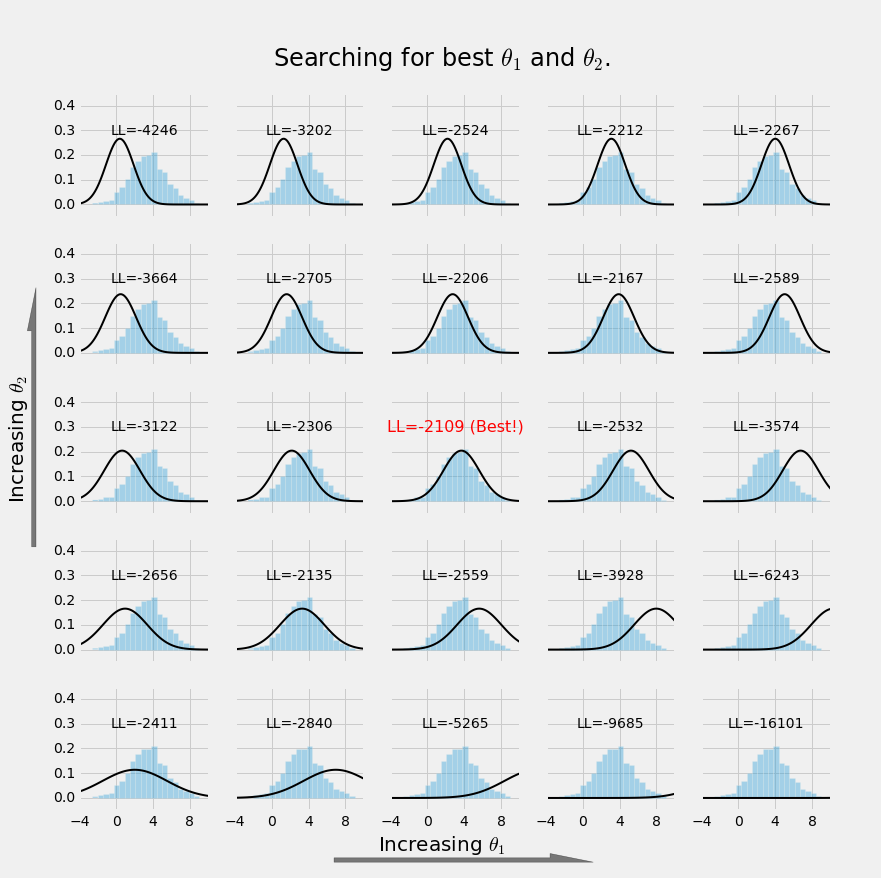

In [4]:
thetas = []
for mi in mus:
    for stdj in stds:
        thetas.append([mi/(stdj**2),-1/(2*(stdj**2))])
        
thetas1, thetas2 = zip(*thetas)

thetas1 = np.linspace(min(thetas1),max(thetas1),5)
thetas2 = np.linspace(min(thetas2),max(thetas2),5)

fig, axarr, ax_all = setup_grid_fig(r'$\theta_1$',r'$\theta_2$')

LLs = {}

for i, thi in enumerate(thetas1):
    for j, thj in enumerate(thetas2):
        
        axarr[j,i].hist(data_normal,bins=20,alpha=.4,normed=True)
        
        axarr[j,i].xaxis.set_major_locator(ticker.MultipleLocator(4))
        axarr[j,i].yaxis.set_major_locator(ticker.MultipleLocator(.1))
        axarr[j,i].set_ylim(ylims)
        axarr[j,i].set_xlim(xlims)
        
        stdj = np.sqrt(-1/(2*thj))
        mi = thi*(stdj**2)
        
        axarr[j,i].plot(x,norm(loc=mi,scale=stdj).pdf(x),'k-',linewidth=2)
        
        LL = np.sum(norm(loc=mi,scale=stdj).logpdf(data_normal))
        
        LLs[(thi,thj)] = LL
        
min_LL = np.max(list(LLs.values()))
for i, thi in enumerate(thetas1):
    for j, thj in enumerate(thetas2):
        
        LL = LLs[(thi,thj)]

        LL_text = 'LL={}'.format(str(LL)[:str(LL).index('.')])
        
        if LL == min_LL:
            LL_text += ' (Best!)'
            best_theta = np.array([thi,thj])
            color = 'red'
            fs = 16
        else:
            color = 'black'
            fs = 14
            
        axarr[j,i].text(3,.3,LL_text,
                        color=color,fontsize=fs,
                        va='center',ha='center')

It's worth stating it again: this is the *exact same thing* as finding the best mean and variance. We just did it in different terms. But the crazy thing is.. nearly every distribution you've heard of can be re-worked into this form. In other words, we can do the equivalent of finding $\mu^*$ and $\sigma^{2*}$, but for a huge range of distributions.

### So what is the fully general exponential family?

According to the exponential family, the probability of a vector $\mathbf{x}$ according to a parameter vector $\boldsymbol{\theta}$ is

$$
\begin{align}
p(\mathbf{x}|\boldsymbol{\theta})=&\frac{1}{Z(\boldsymbol{\theta})}h(\mathbf{x})\exp\Big\{{T(\mathbf{x})\cdot\boldsymbol{\theta}\Big\}}\\
\end{align}
$$

$Z(\boldsymbol{\theta})$ is called the partition function and it's there to ensure that $p(\mathbf{x}|\boldsymbol{\theta})$ sums to 1 over $\mathbf{x}$. That is

$$
Z(\boldsymbol{\theta}) = \int h(\mathbf{x})\exp\Big\{{T(\mathbf{x})\cdot\boldsymbol{\theta}\Big\}} \nu(d\mathbf{x})
$$

$\nu(d\mathbf{x})$ refers to the 'measure' of $\mathbf{x}$. It's there to generalize the idea of 'summing over all possible events' to the correct domain (discrete, continuous or subsets of either). So when we say we 'know' $\nu(d\mathbf{x})$, that means we know how to sum over all possible $\mathbf{x}$'s appropriately. It also may determine the 'volume' of $\mathbf{x}$, though you can get that work done with $h(\mathbf{x})$.

In fact, let's make that separation and say that's what $h(\mathbf{x})$ is - it's the volume  of $\mathbf{x}$. Think of this as the component of $\mathbf{x}$'s likelihood that *isn't* due to it's parameters. This will become more clear with an example.

$T(\mathbf{x})$ is called the 'vector of *sufficient* statistics'. This is a measurement of our data that is 100% of what we need to determine agreement with $\boldsymbol{\theta}$. In other words, if I handed you two vectors ($\mathbf{x}_1$ and $\mathbf{x}_2$) that had the same sufficient statistics (so $T(\mathbf{x}_1) = T(\mathbf{x}_2)$) then these data points would agree with all parameter vectors equally.[1]

There are a few extra details regarding the parameters:

1. We'll only consider parameters for which the partition function is finite. If you look at the partition function, it's quite easy to imagine an integral that diverges. This space of 'legal' parameters is called the natural parameter space.

2. There *should*[Add FN] be no linear dependencies between the parameters (or sufficient statistics) in this representation. That is to say, you should be free to move *all* elements of $\boldsymbol{\theta}$. Said differently, knowing one subset of parameters should never fix the others. If this is true, the representation is said to be *minimal*. There are a few reasons for this. First, you never lose any ability to represent distributions by enforcing it. Second, since we will ultimately be searching over the space of $\boldsymbol{\theta}$, we will have the benefit that different $\boldsymbol{\theta}$'s always imply different distributions. And lastly (and I discovered this painfully), if it's not true, it can mask $Z(\boldsymbol{\theta})$ such that it appears to be zero[2].

That last point will guide how we should think: The length of $\boldsymbol{\theta}$ will determine how many degrees of freedom we have over our probability distributions. So when we choose $T(\mathbf{x}_1)$, we need to think carefully first about it's length.

### The exponential family combines nicely across our data

Before diving into examples, we can immediately notice one thing useful. In this form, think about how the probability of a sample combines to form the probability of all our data.

$$
\begin{align}
\prod_i^N p(\mathbf{x}_i|\boldsymbol{\theta}) & = \prod_i^N h(\mathbf{x}_i)\exp\Big\{{T(\mathbf{x}_i)\cdot\boldsymbol{\theta}-\log Z(\boldsymbol{\theta})\Big\}}\\
& = \Big(\prod_i^N h(\mathbf{x}_i)\Big) \exp\Big\{{\big(\sum_i^N T(\mathbf{x}_i)\big)\cdot\boldsymbol{\theta}-N\log Z(\boldsymbol{\theta})\Big\}}\\
& = h_N(\mathbf{X}) \exp\Big\{{T_N(\mathbf{X})\cdot\boldsymbol{\theta}-N\log Z(\boldsymbol{\theta})\Big\}}\\
\end{align}
$$

Look! That relabeling shows that the probability of *all our data* is just a new distribution in the exponential family. Easy!

Since determining the MLE will involve maximizing the log of this, call that $\mathcal{L}_N(\boldsymbol{\theta})$. That is:

$$
\log \prod_i^N p(\mathbf{x}_i|\boldsymbol{\theta}) = \mathcal{L}_N(\boldsymbol{\theta})
$$

### Ok, but how does this relate to the normal distribution?

So when we fitted our normal distribution, we were quietly making choices with respect to the exponential family form. That is, we were making assertions that implied specific settings to our exponential family. Those assertions were:

1. $x$ could be any real valued number: that sets $\nu(dx)$ which determines how we'll do our integration. That is, we'll integrate over the real line.
2. It's normally distributed, which dictates a few things:
    * It has two degrees of freedom, so that tells us the length of $T(x)$ and $\boldsymbol{\theta}$.
    * $T(x) = [x,x^2]$, which means probabilities are influenced by parameters only via a linear relationship with *these* measurements.
    * $h(x) = 1$, which means that the difference in likelihood between two $\mathbf{x}$ values is due entirely the parameters. In other words, all $x$'s have the same size.

From here, the definition of the exponential family will dictate the rest. That is:

$$
\begin{align}
Z(\boldsymbol{\theta}) = & \int h(\mathbf{x})\exp\Big\{{T(\mathbf{x})\cdot\boldsymbol{\theta}\Big\}} \nu(d\mathbf{x})\\
= & \int \exp\Big\{{ \left[\begin{array}{cc}
x & x^2\end{array}\right] \cdot \left[\begin{array}{c}
\theta_1\\
\theta_2
\end{array}\right] \Big\}} dx \\
= & \exp\Big\{ \frac{-\theta^2_1}{4\theta_2} - \frac{1}{2}\log(-2\theta_2) - \frac{1}{2}\log(2\pi)\Big\}
\end{align}
$$

Now that we have this, we can determine $\mathcal{L}_N(\boldsymbol{\theta})$:

$$
\begin{align}
\mathcal{L}_N(\boldsymbol{\theta}) = & \sum_i^N\log \mathcal{N}(x_i | \mu,\sigma^2) \\
= & \left[\begin{array}{cc}
\sum_i^N x_i & \sum_i^N x_i^2\end{array}\right]\left[\begin{array}{c}
\theta_1\\
\theta_2
\end{array}\right] - N\big( \frac{-\theta^2_1}{4\theta_2} - \frac{1}{2}\log(-2\theta_2) - \frac{1}{2}\log(2\pi)\big)
\end{align}
$$

Now picking the best $\theta_1$ and $\theta_2$ (maximizing $\mathcal{L}_N(\boldsymbol{\theta})$) will be the exact same procedure we did earlier.

### What's so useful about the generalization?

The reason for this rephrasing is it reveals all the remarkable degrees of freedom the exponential family rewards us. We didn't *need* to say $x$ was real valued - that was our choice. We didn't *need* to say the sufficient statistics were $[x,x^2]$, we could have picked anything! So let's use those degrees of freedom in another example. Let's say I come across data like this:

![title](BinomialData.png)

Hmm, these aren't numbers. We'll let's make some choices:

1. $\nu(dx)$ should mean we sum over the two possible outcomes ($x=A$ or $x=B$)
2. I suspect only one degree of freedom is appropriate here. With that, I suggest we use an indicator function:
$$
    T(x)= 
\begin{cases}
    1 & \text{if } x = A\\
    0              & \text{if } x = B
\end{cases}
$$
which can be represented as $\mathbb{1}[x=A]$
3. Outside of something that relates to the parameters, I have no reason to think $x=A$ has a greater volume than $x=B$ (or visa versa), so let's say $h(x)=1$.

We've made all our choices - What does this imply about $Z(\boldsymbol{\theta})$?

$$
\begin{align}
Z(\theta) = & \int h(x)\exp\Big\{{T(x)\cdot\theta\Big\}} \nu(dx)\\
= & \int \exp\Big\{{\mathbb{1}[x=A]\cdot\theta\Big\}} \nu(dx)\\
= & \sum_{x \in \{A,B\}} \exp\Big\{{\mathbb{1}[x=A]\cdot\theta\Big\}}\\
= & \exp(\theta) + 1
\end{align}
$$

And now we can write $p(x|\theta)$:

$$
\begin{align}
p(x|\theta)= &\frac{1}{Z(\theta)}h(x)\exp\Big\{{T(x)\cdot\theta\Big\}}\\
= &\frac{1}{\exp(\theta) + 1}\exp\Big\{{\mathbb{1}[x=A]\cdot\theta\Big\}}\\
\end{align}
$$

Or, written out more explicitly:

$$
\begin{align}
p(x=A|\theta) = &\frac{\exp(\theta)}{\exp(\theta) + 1}\\
p(x=B|\theta) = &\frac{1}{\exp(\theta) + 1} = 1 - p(x=A|\theta)
\end{align}
$$

Since we can choose $\theta$ to yield any value in [0,1] for $p(x=A|\theta)$, we see this distributions just assigns a constant probability to the events $x=A$ and $x=B$ - in other words, it's a Bernoulli random variable. 

So to pick the most likely parameters, we optimize $\mathcal{L}_N(\theta)$, just like we did in the case of the normal. Here, there is a simple analytic solution (just set the derivative to zero and see what falls out).

So one set of choices led us directly to the normal distribution while another set led us to the Bernoulli distribution. What else can we generate?

### Try something harder!

What if we came across data like this:

![title](MultiData.png)

Well this is odd. Now $\mathbf{x}$ is a length 3 vector and it's got this unusual constraint where the elements sum to 10. Ok, deep breath - let's start from our familiar spot:

1. How should we think about $\nu(d\mathbf{x})$? How should we think about all possible events that we should sum over? Said differently, what are the legal observations you could make for this data? Well it's any 3 nonnegative integers such that their sum is 10. Here, I'll write them out for you:

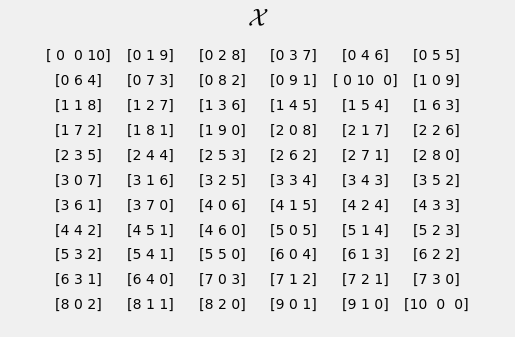

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title(r'$\mathcal{X}$',fontsize=24)

where = 0

for i in np.linspace(11/12,1/12,11):
    for j in np.linspace(1/7,6/7,6):
        string = str(mult_combs[where])
        ax.text(j,i,string,va='center',ha='center')
        where += 1

So I just need to sum over all these. Let's call this set $\mathcal{X}$.

2. How many degrees of freedom should our modeling allow? Well I suspect there'll be a parameter for each column, but the constraint that their sum is 10 will subtract one, so le't say there are 2 degrees of freedom.

3. What is $T(\mathbf{x})$? The most natural thing I can think of is the data itself, so let's go with the first two elements of $\mathbf{x}$. We aren't losing information regarding the last element, since our distribution will also 'know' that the sum is 10.

4. What is $h(\mathbf{x})$? In other words, should one observation of $\mathbf{x}$ ever be considered more likely than another, regardless of what parameter vector $\boldsymbol{\theta}$ we have? From this angle, I have no clue, but it's not simple enough for me to say $h(\mathbf{x})=1$. To crystalize our understanding, let's think about how we would generate $\mathbf{x}$ ourselves. One way is to make 10 draws (from some distribution I don't yet know) and then aggregate the results. So, for example,  $AABBCABABC \implies [4,4,2]$. The useful thing here is that all possible sequences will map to all events of $\mathcal{X}$. Now from this angle, do some observations seem more likely then others (even though we can't reference the distributed that generates a single draw)? Well, some observations are mapped to by more sequences than others. For example, the only thing that maps to [10,0,0] is $AA \cdots A$ while [9,1,0] is mapped to by 10 sequences ($BA\cdots A,AB\cdots A,\cdots, AA\cdots B$). So it seems the latter observations is 10 times bigger than the former. Notice this is true *despite not knowing the parameters*. So let's make $h(\mathbf{x})$ the number of sequences that map to $\mathbf{x}$. If you remember some combinatorics, that is:
    
    $$
    h(\mathbf{x}) = \frac{10!}{(x_1!)(x_2!)(x_3!)}
    $$
    
Ok, we've made all our choices so we should be good to go. The partition function is this guy:

$$
\begin{align}
Z(\boldsymbol{\theta}) = & \int h(\mathbf{x})\exp\Big\{{T(\mathbf{x})\cdot\boldsymbol{\theta}\Big\}} \nu(d\mathbf{x})\\
= & \sum_{\mathbf{x}\in \mathcal{X}} \frac{10!}{(x_1!)(x_2!)(x_3!)}\exp\Big\{\mathbf{x}_{:2}\cdot\boldsymbol{\theta}\Big\}\\
= &  (\exp(\theta_1) + \exp(\theta_2) + 1)^{10}
\end{align}
$$

If you're wondering how I got from the second line to the third, the answer is.. I don't know. I just, from an entirely separate arena, happen to know that's true. So now we may write the expression for the probability:

$$
\begin{align}
p(\mathbf{x}|\boldsymbol{\theta}) = & \frac{1}{(\exp(\theta_1) + \exp(\theta_2) + 1)^{10}}\frac{10!}{(x_1!)(x_2!)(x_3!)}\exp\Big\{\mathbf{x}_{:2}\cdot\boldsymbol{\theta}\Big\}\\
\end{align}
$$

At this point, we have everything we need to optimize $\mathcal{L}_N(\boldsymbol{\theta})$. But if you're feeling uneasy with this unusual form that's followed from our rather basic choices, I can tell you something relaxing. This is actually identical to this form:

$$
p(\mathbf{x}|\boldsymbol{\theta})= \frac{10!}{(x_1!)(x_2!)(x_3!)}p_1^{x_1}p_2^{x_2}p_3^{x_3}
$$

where $\theta$ has been rewritten in terms of probabilities $p_1$, $p_2$ and $p_3$. These probabilities refer to the chances of a particular draw when we were generating our sequences earlier. In other words, this was just the multinomial distribution.

## Still not impressed

These examples should communicate the flexibility of the exponential family. To cover more ground with fewer words, I'll just show you a taste of the diversity of distributions given by different choices of $h(\mathbf{x})$ and $T(\mathbf{x})$. From the wiki page:

![title](ExpDiversity.png)

Look at that. That sample is almost a college semester worth of distributions. And we can handle any of them, just by turning the dials on this exponential machine.


### Any other insights?

There is some intuition that remains to be had. When we 'pick the most appropriate $\boldsymbol{\theta}$', we were maximizing this guy:

$$
\begin{align}
\log \prod_i^N p(\mathbf{x}_i|\boldsymbol{\theta}) & = \log h_N(\mathbf{X}) + T_N(\mathbf{X})\cdot\boldsymbol{\theta}-N\log Z(\boldsymbol{\theta})
\end{align}
$$

(which we called $\mathcal{L}_N(\boldsymbol{\theta})$). Up until this point, we have been optimizing this rather blindly. But in reality, the first step is to compute the gradient, so let's start there:

$$
\begin{align}
\frac{\partial \mathcal{L}_N(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = & T_N(\mathbf{X}) - N \frac{\partial \log Z(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} \\
\end{align}
$$

Ok, we got this. Let's figure out $\frac{\log \partial Z(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}}$:

$$
\begin{align}
\frac{\log \partial Z(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = & \frac{1}{Z(\boldsymbol{\theta})}\frac{\partial}{\partial \boldsymbol{\theta}} \int h(\mathbf{x})\exp\Big\{{T(\mathbf{x})\cdot\boldsymbol{\theta}\Big\}} \nu(d\mathbf{x})\\
= & \frac{1}{Z(\boldsymbol{\theta})}\int T(\mathbf{x}) h(\mathbf{x})\exp\Big\{{T(\mathbf{x})\cdot\boldsymbol{\theta}\Big\}} \nu(d\mathbf{x})\\
\end{align}
$$

It's a bit sneaky, but the integrand just became a vector (due to multiplication by $T(\mathbf{x})$). Now if we look closely, it's just a probability weighted average of $T(\mathbf{x})$. In other words, it's the expectation of $T(\mathbf{x})$ under the parameters dictated by $\boldsymbol{\theta}$. That is:

$$
\begin{align}
\frac{\log \partial Z(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = & \mathbb{E}_{\mathbf{x} \sim p(\mathbf{x}|\boldsymbol{\theta})}\big[ T(\mathbf{x}) \big]
\end{align}
$$

So a rescaled version (scaling doesn't matter) of our gradient is:

$$
\begin{align}
\frac{1}{N} \frac{\partial \mathcal{L}_N(\boldsymbol{\theta})}{\partial \boldsymbol{\theta}} = & \frac{1}{N} T_N(\mathbf{X}) - \mathbb{E}\big[ T(\mathbf{x}) \big] \\
\end{align}
$$

How wild is that!? We have this super general optimization problem and out pops this very short, very intuitive expression for the gradient. The gradient tells us what direction (in the space of $\boldsymbol{\theta}$'s) to move. This says 'move in the direction that reduces the biggest differences between our calculated/observed sufficient statistics and those expected under the current choice of $\boldsymbol{\theta}$.

Another way to see this is that at the maximum, the gradient is zero. So when we found our best parameters, those parameters will dictate an expectation of sufficient statistics that are equal to our observed averaged sufficient statistics.

## What's the catch?

This, unfortunately, isn't a cure all solution. There's a catch - it's the normalizer $Z(\boldsymbol{\theta})$. The difficulty is it's a summation over $\mathcal{X}$, which can be exponentially large. For example, think about our multinomial problem. If we had just 10 categories and they summed to 40, we already have over a billion elements in $\mathcal{X}$. In other circumstances, this issue can be much worse.

# Extensions:

1. Mention GLMs

### Where'd you learn about this?

There were three great references in producing this:

1. Kevin Murphy's Machine Learning: A Probabilistic Perspective (chapter 9)
2. This pdf floating around online: https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter8.pdf Which I suspect is by Michael I Jordan.
3. The wiki page and the army of smart people who organized it. Wikipedia - you're awesome.

### Footnotes

[1] I realize 'agreement with parameters' is a bit vague. The actual definition is .. [ELAB]
[2] I don't understand why exactly it's true, but it's mentioned here: https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter8.pdf
[3] It might be confusing


### Scrap

In [68]:
size_of_X(40,10) - 1000000000

1054455634.0

In [8]:
# M = 5
# x_len = 3

# def n_choose_subsets(x):
#     numerator = np.math.factorial(np.sum(x))
#     denominator = np.prod(np.array([np.math.factorial(xi) for xi in x]))
    
#     return (numerator/denominator)

# def prob_unnorm(x,theta):
    
#     return n_choose_subsets(x)*np.exp(np.sum(x[:2]*theta))

# def partition(theta):
    
#     count = 0
#     Z = 0
#     for x1 in range(M+1):
#         for x2 in range(M-x1+1):
#             x3 = M-(x1+x2)
#             x = np.array([x1,x2,x3])
#             count += 1
#             Z += prob_unnorm(x,theta)
            
#     return Z, count
            
# count_analytic = np.math.factorial(M+x_len-1)/(np.math.factorial(M)*np.math.factorial((M+x_len-1)-M))

# def my_prob(x, theta):
#     Z, count = partition(theta)
#     return prob_unnorm(x,theta)/Z

# def their_prob(x,theta):
#     return n_choose_subsets(x)*np.exp(np.sum(x*theta))


# # def theta_to_prob(theta):
# #     p1 =

# theta = np.array([.2,.1])
# p3 = 1/(np.exp(theta[0])+np.exp(theta[1])+1)
# # x = [2,2,1]
# # print(my_prob(x, theta))
# # print(their_prob(x,theta))
# print(np.log(partition(theta)))
# # print(M*np.log(1/p3))
# val = (np.exp(theta[0])+np.exp(theta[1])+1)
# print(M*np.log(val))
# print(val**M)
# print(partition(theta))

In [9]:
# def Exponential1DReal(hx,tx, theta):
    
#     assert len(tx(0)) == len(theta)
     
#     def prob_unnorm(x):
#         return hx(x)*np.exp(np.sum(tx(x)*theta))
    
#     Z =  integrate.quad(prob_unnorm, -np.inf, np.inf)[0]

    
#     def prob(x):
#         return prob_unnorm(x)
    
#     return prob

# mu = .1
# sigma2 = 2
# # theta1 = mu/sigma2
# # theta2 = -1/(2*sigma2)
# theta1 = -1

# # tx = lambda x : np.array([np.log(x),np.log(x)**2])
# tx = lambda x : np.array([x])
# hx = lambda x : 1
# theta = np.array([theta1])
# my_norm = Exponential1DReal(hx,tx, theta)

# real_line = np.linspace(0,5,100)

# # integrate.quad(my_norm, -np.inf, np.inf)[0]

# # # def normZ(theta1,theta2):
# # #     logZ = -(theta1**2)/(4*theta2) - (1/2)*np.log(-2*theta2) - (1/2)*np.log(2*np.pi)
# # #     return np.exp(logZ)

# for i in real_line:
#     print('--------')
#     print(my_norm(i))
# # #     print(normZ(theta1,theta2))
# #     print(norm.pdf(i,mu,np.sqrt(sigma2)))

# pd.Series([my_norm(i) for i in real_line],index=real_line).plot(kind='line')
    
# # rv = norm()
# #     my_norm    
# # # x = 0

# # # hx(x)*np.exp(np.sum(tx(x)*theta))
# # # tx(x)*theta

# What is the exponential family?

Structure:

[A lot of exponential family tutorials define the exponential family and show how all the familiar distributions are special cases. This is going for showing the generality of the exponential family to familiar circumstances, but it doesn't show good exponential family reasoning. Meaning it doesn't teach you to reason from the generality of exponential families. Here, we will reason from the data and how the exponential family can handle a wide range.]

Talk about the familiar case of estimating the parameters of the normal distribution. Show the vector as a scatter plot and a histogram. "How would you figure out the normal distribution this came from? Well you'd plug in the empirical mean/variance. The analytic solution is distracting from the general view. What you're actually doing is maximizing this guy (show formula). So you could think (naively) about varying mu/sigma over all values and maximizes the result. (Show a grid of graphs where we vary mu and sigma and show the PDF over the histogram. Highlight the max)

Now I'm going to do the *exact same thing*, but I'm going to rewrite some of the algebra and name a few things.

(See the Gaussian section of https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter8.pdf)

Create labels on the expanded exponential family-like equation:

    1. measurements of our data
    2. a function of our parameters that get multiplied by our measurements
    3. a function of our parameter that get substracted out
    4. a number (the 1/sqrt(2pi))
    
Now let's relabel [mu/sigma^1, -1/2sigma^2] as [theta1, theta2]. You'd agree that if I know that values of [theta1, theta2], I'd also know the values of mu and sigma^2, yes? (2 equations, 2 variables). So that means I know A(\mu,\sigma)

(Describe how you can now search over theta1, theta2)

This right here is the heart of the exponential family. What's hidden here is the implicit choices we made that led us to the normal distribution, rather than something else. I'll get into that, but now I'll define the exponential family in all it's glory.

(Define)

(Talk about \eta(x) and how it's a bit of a trick to get us to know what to sum over.)

So when I said 'we suspect it's normally distributed', that's a choice right there! We are basically saying the only thing that matters about the data is:

h(x) = 1
T(x) = [x,x^2] (or a sum? - actually no, start about reasoning about one data point at a time)

But we need, so that means:

A(theta) = (something of theta)

since this is needed to make sure the distribution sums to 1.

Then when we answer the question 'which normal distribution fits best?' we find the theta1 and theta2 that maximize that objective. Now in this specific instance, we *could* rewrite theta1 and theta2 to be our normal parameters? But what's the point? Theta1 and theta2 make more sense in the broader context.

Now say you came across data like this (describe 1-0 data). Now let's come at it from the direction of the exponential family. What do you think matters about one piece of data? The only thing I can think of if it's a 1 or not. So let's choose

h(x) = 1
T(x) = x

We need that integrate to 1 situation, so that makes:

A(theta) = (something of theta)

Great, now find the best theta1 across all the data.



We're done (but explain how we just fit a bernoulli).

Let's try something harder, what if each data point was the number of bernoulli success out of N trials. So we have M pieces of data like this:

[Show binomial data]

It's hard to think directly about the measurement of the data that matters, but it might be easier if we think about what's 'underneath' all this. That would look like:

[Show one binomial datapoint expanded out into N bernoulli trials]

So what's the probability of observing a certain sum? Well we need that many bernoulli trials to go off, but they can go off in any number of (n choose x) ways. So the probability is:

(Show binomial pmf in exponential family form)

ahh so now we see the point of h(x). It tells us how *big* x is, independent of parameters. So if I have a binomial with N = 6, then the event x = 3 is (n choose x) times larger than the atomic event the exponential is measuring. This is true *despite* our settings of the parameters.

Ok, but discrete might be too easy. Let's try something harder. What if I have data like this:

[Show exponential data]

What measure about this matters? I don't know, hmm. Let's take a tra

Hmm, I don't know how to measure this. But maybe I can build it out of stuff I do understand? Expand



2. "and THIS is what the exponential family is about" it's a general framework 

2. The procedure mentioned

I'll give a different perspective on the exponential family. If you visit the wiki page, you'll read its definition and its wonderfully general properties. That's all well and good, but it doesn't well represent how it's useful to a data scientist. I'll try to do that here. I'll avoid some typical extensions, because they distract from a good starting point. I'll start with a real simple problem, how the exponential family helps in that circumstance and how it can, in fact, help in more broader circumstances. After all this, you should be able to put this knowledge in your pocket and actually use the exponential family in all it's general glory. Now..

[Insert Vegeta picture with the let us begin caption]

Let's say my data is a vector of real values scalars $\{x_{i}\}_{i=1}^{N}$ and I *suspect* it's normally distributed. The goal is to determine *which* normal distribution it comes from. This might sound trivial - the empirical mean/variance tell us which normal distribution. But that answer is representative of the broader picture. What we are really doing is answering the question:

“What are the parameters of the normal distribution that maximize the data I'm seeing?”

In the simple case of the normal distribution, we *happen* to have a way to calculate that answer immediately from the data. But we don't always. So let's handicap

If you'd like to estimate the parameters of the normal distribution, you do the typical routine: the mean is the average and the variance is the empirical variance

If you know how to approach this, forget your approach!

Let's define it. We seek to define some probability distribution over a vector of observations. We do that with this magical device:

$$
p(\mathbf{x}|\boldsymbol{\theta})=\frac{1}{Z(\boldsymbol{\theta})}h(\mathbf{x})e^{T(\mathbf{x})\cdot\boldsymbol{\theta}}
$$